In [1]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path to directory containing code of this case

In [2]:
new_path = r'/home/users/suihong/3-Cond_wellfacies-upload/'
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = '/scratch/users/suihong/DataSets(MultiChannels_Version4_Consistency)/'

#### Set path to trained network

In [4]:
# 19200 means totally 19200 thousand training images (facies models) used for the training
network_dir = '/scratch/users/suihong/ProGAN_MultiChannel_Reusults_ConditionedtoMultiConditions_TF/009-pgan-conditionalWellEnlargement-2gpu/'
network_name = 'network-snapshot-016000.pkl'

### 1. Fetch dataset

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset
# tfrecord_dir='TestData' to fetch test dataset, if tfrecord_dir='TrainingData' to fetch training dataset
# labeltypes: 0 for 'channelorientation', 1 for 'mudproportion', 2 for 'channelwidth', 3 for 'channelsinuosity'
# well_enlarge: if True, well points occupy 4x4 area, otherwise occupy 1x1 area
test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', labeltypes = [1,2,3], well_enlarge = True, shuffle_mb = 0, prefetch_mb = 0)

# labels are from -1 to 1
image_test, label_test = test_set.get_minibatch_imageandlabel_np(3000)  
probimg_test, wellfacies_test = test_set.get_minibatch_probandwell_np(3000*8)


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 3


In [6]:
print(image_test.shape)
print(label_test.shape)
print(probimg_test.shape)
print(wellfacies_test.shape)

(3000, 1, 64, 64)
(3000, 3)
(24000, 1, 64, 64)
(24000, 1, 64, 64)


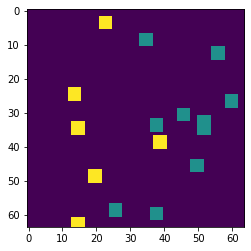

In [7]:
plt.imshow(wellfacies_test[55,0])

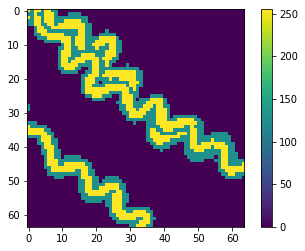

In [8]:
plt.imshow(image_test[60,0])
plt.colorbar()

#### Global features are kept and inputted into Networks with the scale of -1 to 1. To recover the global features into its original scales, use the below transformation functions.


In [9]:
#orit_test = (label_test[:,0]/2+0.5)*168-84
back_ratio_test = (label_test[:,0]/2+0.5)*0.8037109375+0.167724609375
width_test = (label_test[:,1]/2+0.5)*0.8+2.7
amwv_ratio_test = (label_test[:,2]/2+0.5)*0.4866197183098592+0.06338028169014084

### 2. Import pre-trained Network

In [10]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)

/share/software/user/open/py-tensorflow/1.12.0_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '




### 3. Random simulate based on pretrained Network and mannual inspection



**Randomly sample well facies from test facies models **

In [20]:
well_points = np.zeros([32, 1, 64, 64], dtype = int)
for i in range(32):
    well_points_num = np.random.RandomState(3*i).choice(np.arange(5, 8), 1)  # Random choose the expected total number of well points
    xs = np.random.RandomState(i*i*i*56).choice(64, well_points_num)
    ys = np.random.RandomState(i*i*2+20).choice(64, well_points_num)
    well_points[i, 0, xs, ys] = 1

well_facies = np.where(well_points * image_test[:32]>0, 1, 0) # image_test is from 0 to 155
well_facies = np.concatenate([well_points, well_facies], 1) 

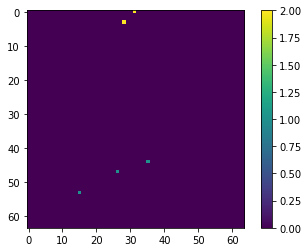

In [21]:
# to show well facies code
plt.imshow((well_facies[0, 1] + 1) * well_facies[0, 0])
plt.colorbar()
#plt.savefig(network_dir + "Tested well facies.png", dpi=200) 

In [22]:
### Enlarge areas of well points into 4 x 4 as inputs
with tf.device('/gpu:1'):
    well_facies = tf.cast(well_facies, tf.float32)
    well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,4,4], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    well_facies_el = sess.run(well_facies_enlarge)

# make mask of output well facies data only for better displaying in following figure
well_facies_onechannel = well_facies[:,0:1]+well_facies[:,1:2]
well_facies_onechannel_mask = np.ma.masked_where(well_facies_onechannel == 0, well_facies_onechannel)
well_facies_el_onechannel = well_facies_el[:,0:1]+well_facies_el[:,1:2]
well_facies_el_onechannel_mask = np.ma.masked_where(well_facies_el_onechannel == 0, well_facies_el_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

In [24]:
print(Gs.input_shapes)

[[None, 128], [None, 0], [None, 2, 64, 64]]


**Each row has the same input well facies data but different latent vectors**

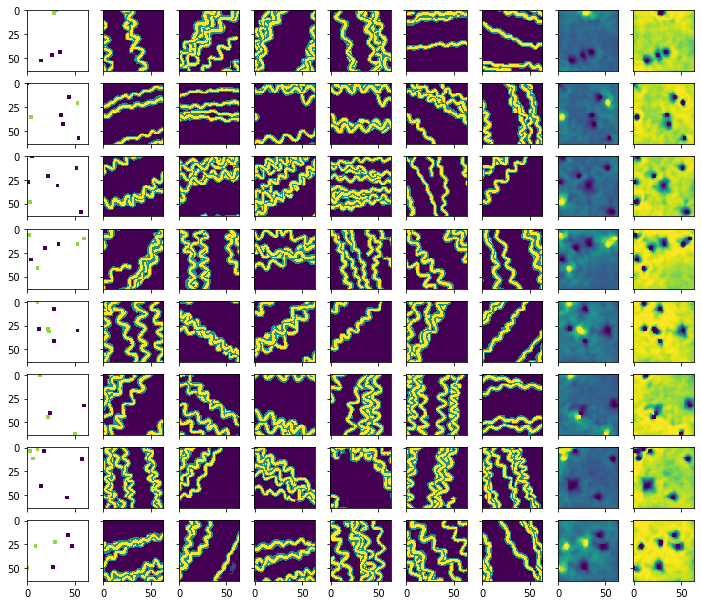

In [27]:
fig, ax = plt.subplots(8, 9, sharex='col', sharey='row')
fig.set_size_inches(12, 10.5, forward=True)

for i in range (8):
    ax[i, 0].imshow(well_facies_el_onechannel_mask[i,0], cmap=cmap_well, vmin=1, vmax=2.2)
    
    latents_plt = np.random.randn(500, Gs.input_shapes[0][1]) 
    labels_plt = np.random.uniform(-1, 1, (500, 0))  
    well_facies_plt = np.repeat(well_facies_el[i:i+1], 500, axis=0)

    # Run the generator to produce a set of images.
    images_plt = Gs.run(latents_plt, labels_plt, well_facies_plt) #, probimages_plt
    images_plt = np.where(images_plt< -0.7, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt>= -0.4) & (images_plt<= 0.4), 0, images_plt)
    
    images_plt_a = (np.where(images_plt> -0.4, 1, images_plt) + 1)/2
    images_plt_average = np.average(images_plt_a, axis = 0)
    images_plt_variance = np.var(images_plt_a, axis = 0)
    
    for j in range(6):
        ax[i, j+1].imshow(images_plt[j,0,:,:])
    ax[i, 7].imshow(images_plt_average[0], vmin = 0, vmax = 1)   # E-type
    ax[i, 8].imshow(images_plt_variance[0], vmin = 0, vmax = 0.25)  # Variance
plt.savefig(network_dir + "simulations conditioned to well facies.png", dpi=200) 

### 4. Quantitative assessment of well facies reproduction accuracy

In [28]:
def get_random_well_facies_data(images_num):
    well_points = np.zeros([images_num, 1, 64, 64], dtype = int)
    for i in range(images_num):
        well_points_num = np.random.RandomState(3*i).choice(np.arange(8, 16), 1)  # Random choose the expected total number of well points
        xs = np.random.choice(64, well_points_num)
        ys = np.random.choice(64, well_points_num)
        well_points[i, 0, xs, ys] = 1

    # Using training facies models to sample faices types at well  points
    well_facies = np.where(well_points * image_test[:images_num]>0, 1, 0)
    well_facies = np.concatenate([well_points, well_facies], 1)      
 
    return well_facies

In [29]:
def generate_images(realization_num, well_facies):
    # Generate latent vectors.
    latents_plt = np.random.randn(realization_num, Gs.input_shapes[0][1]) 
    labels_plt =  np.random.uniform(-1, 1, (realization_num, 0)) 
    well_facies_plt = well_facies

    # Run the generator to produce a set of images.
    images_plt = Gs.run(latents_plt, labels_plt, well_facies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.15, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.15), 0, images_plt)
    return images_plt

In [30]:
def well_points_accuracy(well_facies, fake_imgs_a):
    gg = well_facies_smp_train_facies[:,0:1] + well_facies_smp_train_facies[:,1:2]
    
    recognized_f1 = np.where((gg==2) & (well_facies_smp_train_facies[:,0:1] * (fake_imgs_a+1) > 0.8), 1, 0)
    f1_prob = np.sum(recognized_f1)/np.sum(np.where(gg==2,1,0))

    recognized_f0 = np.where((gg==1) & (well_facies_smp_train_facies[:,0:1] * (fake_imgs_a+2) ==1), 1, 0)
    f0_prob = np.sum(recognized_f0)/np.sum(np.where(gg==1,1,0))
    
    return f1_prob, f0_prob

In [31]:
def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:1'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,4,4], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

In [32]:
images_num = 1000
well_facies_smp_train_facies = get_random_well_facies_data(images_num)
well_facies_smp_train_facies_el = enlarge(well_facies_smp_train_facies)      
fake_imgs = generate_images(images_num, well_facies_smp_train_facies_el)
f_c_prob, f_m_prob = well_points_accuracy(well_facies_smp_train_facies, fake_imgs)
print(f_c_prob) # well facies reproduction accuracy for input channel complex facies
print(f_m_prob) # well facies reproduction accuracy for input mud facies

1.0
0.9930273097036607
